In [1]:
%load_ext autoreload
%autoreload 2

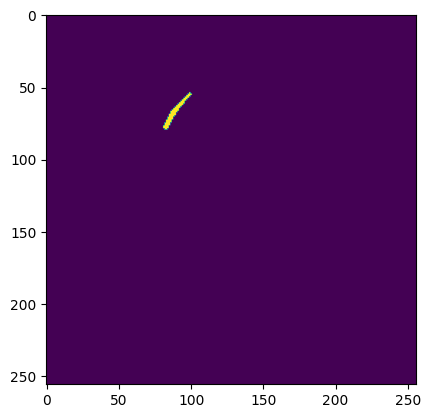

In [9]:
from src.ds import Dataset
from matplotlib import pyplot as plt
import random
import numpy as np

ds = Dataset(false_color=True, t=[4])

ix = random.randint(0, len(ds)-1)
img, mask = ds[ix]
mask = mask.numpy().astype(np.uint8)

plt.imshow(mask)
plt.show()

In [10]:
import cv2
import numpy as np

def hough_transform(img, rho_res=1, theta_res=np.pi/180, threshold=100):
    """
    Apply the Hough transform to find lines in the image.

    Parameters:
    - img: binary image where lines are to be detected.
    - rho_res: distance resolution of the accumulator in pixels.
    - theta_res: angle resolution of the accumulator in radians.
    - threshold: accumulator threshold parameter. Only those lines are returned that get enough votes (> `threshold`).

    Return:
    - lines: output vector of lines. Each line is represented by a 2 or 3 element vector (rho, theta) or (rho, theta, votes).
    """

    # Use OpenCV's Hough Line Transform function
    lines = cv2.HoughLines(img, rho_res, theta_res, threshold)

    return lines

In [4]:
# lines = hough_transform(mask)

# lines.shape

(26, 1, 2)

In [11]:
import matplotlib.pyplot as plt

def plot_lines(img, rho_res=1, theta_res=np.pi/180, threshold=100):
    """
    Plot lines on the image.

    Parameters:
    - img: the original image.
    - lines: output from HoughLines function.

    Return:
    - plot the image with lines.
    """
    # Create a color image to overlay lines on
    lines = hough_transform(img, rho_res, theta_res, threshold)
    line_img = np.copy(img)*255
    line_img = cv2.cvtColor(line_img, cv2.COLOR_GRAY2RGB)

    # If cv2.HoughLines found at least one line
    if lines is not None:
        for i in range(len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a * rho
            y0 = b * rho

            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # Display the image with lines
    plt.imshow(line_img)
    plt.show()
    return lines


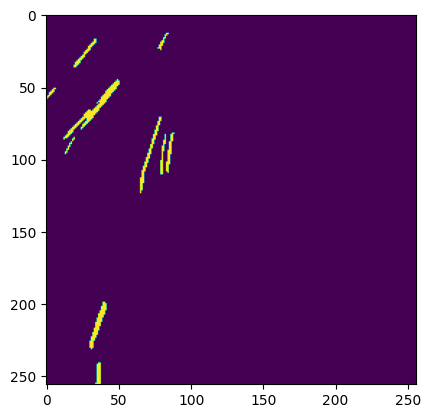

In [78]:
ix = random.randint(0, len(ds)-1)
img, mask = ds[ix]
mask = mask.numpy().astype(np.uint8)

plt.imshow(mask)
plt.show()

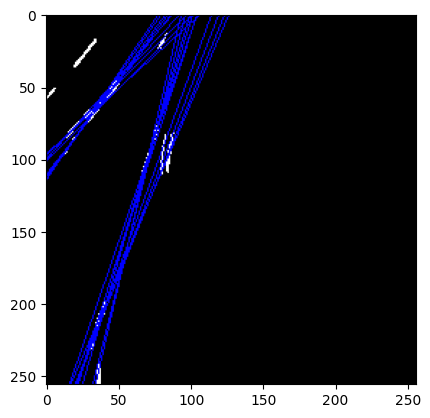

In [79]:
lines = plot_lines(mask, 1, np.pi/180, 40)

In [80]:
len(lines)

20

In [121]:
def calculate_score(img, lines):
    """
    Calculate a Dice score based on the number of correctly detected lines.

    Parameters:
    - img: the true binary segmentation.
    - lines: output from HoughLines function.

    Return:
    - score: the calculated Dice score.
    """
    # Initialize score
    score = 0.0

    # Initialize overlap and total elements count
    overlap_count = 0
    total_elements = np.sum(img > 0)

    # If cv2.HoughLines found at least one line
    if lines is not None:
        for i in range(len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a * rho
            y0 = b * rho

            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            # Create a blank image with the same dimensions as the original
            line_img = np.zeros(img.shape, np.uint8)
            cv2.line(line_img, (x1, y1), (x2, y2), 1, 1)

            # Count non-zero pixels that fall on the detected line
            overlap_count += np.sum((line_img & img) > 0)
            total_elements += np.sum(line_img > 0)

        # Compute Dice score
        if total_elements > 0:
            score = (2.0 * overlap_count) / total_elements

    return score

In [122]:
score = calculate_score(mask,lines)
score

0.5533829382246064

In [177]:
from src.module import Module

module = Module()

In [178]:
import torch 

input = torch.randn((10, 256, 256, 1, 3))
output1, output2 = module(input)

In [179]:
output1.shape, output2.shape

(torch.Size([10, 1, 256, 256]), torch.Size([10, 2, 20]))

In [181]:
target = torch.zeros((10, 256, 256)).long()
batch = (input, target)
module.training_step(batch, 0)

torch.Size([10, 256, 256]) torch.Size([10, 2, 20])


/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/core/module.py:406: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(0., grad_fn=<MeanBackward0>)